<a href="https://colab.research.google.com/github/b2204yo/supervisedPetClass/blob/develop/supervisedPetClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Google Driveをマウント

# 新しいセクション

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

In [ ]:
from __future__ import print_function
import keras
from keras.applications import VGG16
from keras.models import Sequential, load_model, model_from_json
from keras import models, optimizers, layers
from keras.optimizers import SGD
from keras.layers import Dense, Dropout, Activation, Flatten
from sklearn.model_selection import train_test_split
from PIL import Image
from keras.preprocessing import image as images

from keras import backend as K
import os
import numpy as np
import glob
import pandas as pd
import cv2


GradCAM の関数

In [ ]:
def Grad_Cam(input_model, pic_array, layer_name):

    # 前処理
    pic = np.expand_dims(pic_array, axis=0)
    pic = pic.astype('float32')
    preprocessed_input = pic / 255.0

    # 予測クラスの算出
    predictions = input_model.predict(preprocessed_input)
    class_idx = np.argmax(predictions[0])
    class_output = input_model.output[:, class_idx]

    #  勾配を取得
    conv_output = input_model.get_layer(layer_name).output   # layer_nameのレイヤーのアウトプット
    grads = K.gradients(class_output, conv_output)[0]  # gradients(loss, variables) で、variablesのlossに関しての勾配を返す
    gradient_function = K.function([input_model.input], [conv_output, grads])  # input_model.inputを入力すると、conv_outputとgradsを出力する関数

    output, grads_val = gradient_function([preprocessed_input])
    output, grads_val = output[0], grads_val[0]

    # 重みを平均化して、レイヤーのアウトプットに乗じる
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # 画像化してヒートマップにして合成
    cam = cv2.resize(cam, (224, 224), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()

    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    jetcam = (np.float32(jetcam) + pic / 2)   # もとの画像に合成
    return jetcam

Downloading the data

In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dogs-vs-cats



Saving kaggle.json to kaggle.json
 97% 784M/812M [00:06<00:00, 233MB/s]
100% 812M/812M [00:06<00:00, 133MB/s]


In [ ]:


!unzip -qq dogs-vs-cats.zip

# !unzip -qq train.zip

In [ ]:
 !unzip -qq train.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Copying images to training, validation, and test directories

In [ ]:
!unzip -qq plasticBottle.zip

replace plasticBottle/normal/normal (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("/content/plasticBottle")
new_base_dir = pathlib.Path("/content/plasticBottle")

def make_subset(subset_name, start_index, end_index):
    for category in ("normal", "pressed"):
        dir = new_base_dir / subset_name / category
        if os.path.isdir(dir) == False:
          os.makedirs(dir)
        fnames = [f"{category} ({i}).jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / category / fname,
                            dst=dir / fname)

make_subset("train", start_index=1, end_index=100)
make_subset("validation", start_index=100, end_index=150)
make_subset("test", start_index=150, end_index=200)

Select learning model

Set picuter setting

In [ ]:
learning_model_name = "MobileNetV2"
# VGG16 : 180, Efficient Net 224

if learning_model_name == "VGG16":
  num_picel_units = 180
  num_epoch = 30
  conv_base  = keras.applications.vgg16.VGG16(
     weights="imagenet",
     include_top=False)

elif learning_model_name == "EfficientNetV2":
  num_picel_units = 224
  num_epoch = 350
  conv_base = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(weights="imagenet")

elif learning_model_name == "MobileNetV2":
  num_picel_units = 160
  num_epoch = 50
  inputs = tf.keras.Input(shape=(num_picel_units, num_picel_units, 3))
  x = tf.keras.layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input)(inputs)
  conv_base = tf.keras.applications.mobilenet_v2.MobileNetV2(
   weights='imagenet',
   input_tensor=x,
   input_shape=(num_picel_units, num_picel_units, 3),
   include_top=False,
   pooling='avg'
)

9406464/9406464 [==============================] - 1s 0us/step


Data preprocessing

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(num_picel_units, num_picel_units),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(num_picel_units, num_picel_units),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(num_picel_units, num_picel_units),
    batch_size=32)

Found 198 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


Displaying the shapes of the data and labels yielded by the Dataset

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 160, 160, 3)
labels batch shape: (32,)


Using image_dataset_from_directory to read images

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(num_picel_units, num_picel_units),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(num_picel_units, num_picel_units),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(num_picel_units, num_picel_units),
    batch_size=32)

Found 198 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


Instantiating the VGG16,ResNet, Mobilenet, Efficient Net convolutional base

In [ ]:
# VGG16
# if learning_model_name == "VGG16":
#   conv_base  = keras.applications.vgg16.VGG16(
#      weights="imagenet",
#      include_top=False)

# # Efficient
# elif learning_model_name == "EfficientNetV2":
#   conv_base = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(weights="imagenet")
conv_base.summary()
conv_base.trainable = False

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 160, 160, 3)  0           ['input_6[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['lambda[0][0]']                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]'

Printing the list of trainable weights before and after freezing

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 156


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Adding a data augmentation stage and a classifier to the convolutional base

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(num_picel_units, num_picel_units, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Evaluating the model on the test set

In [ ]:
conv_base.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 160, 160, 3)  0           ['input_6[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['lambda[0][0]']                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]'

Freezing all layers until the fourth from the last

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Fine-tuning the model

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=num_epoch,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
7/7 [==============================] - 7s 482ms/step - loss: 0.6209 - accuracy: 0.7222 - val_loss: 1.2274 - val_accuracy: 0.3600
Epoch 2/50
7/7 [==============================] - 1s 66ms/step - loss: 0.4080 - accuracy: 0.8232 - val_loss: 1.3116 - val_accuracy: 0.3300
Epoch 3/50
7/7 [==============================] - 1s 67ms/step - loss: 0.4017 - accuracy: 0.8333 - val_loss: 1.4011 - val_accuracy: 0.3100
Epoch 4/50
7/7 [==============================] - 1s 69ms/step - loss: 0.3537 - accuracy: 0.8333 - val_loss: 1.4920 - val_accuracy: 0.3200
Epoch 5/50
7/7 [==============================] - 1s 69ms/step - loss: 0.3327 - accuracy: 0.8636 - val_loss: 1.5545 - val_accuracy: 0.3100
Epoch 6/50
7/7 [==============================] - 1s 68ms/step - loss: 0.3127 - accuracy: 0.8687 - val_loss: 1.6261 - val_accuracy: 0.2800
Epoch 7/50
7/7 [==============================] - 1s 68ms/step - loss: 0.2690 - accuracy: 0.9040 - val_loss: 1.6913 - val_accuracy: 0.2900
Epoch 8/50
7/7 [==========

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

4/4 [==============================] - 1s 26ms/step - loss: 1.1941 - accuracy: 0.3200
Test accuracy: 0.320


Plot result graph

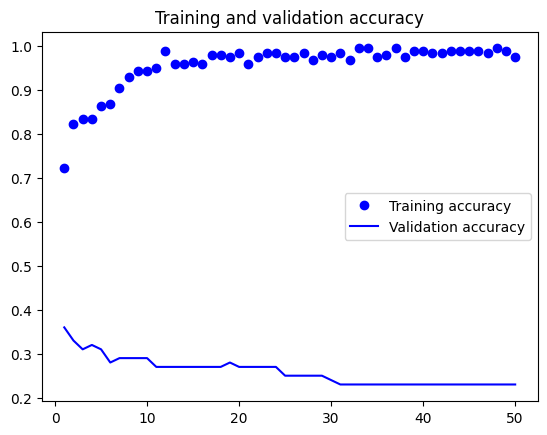

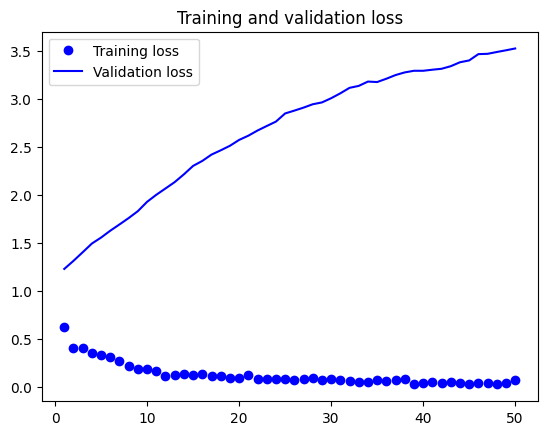

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

評価と予測をする

Predictions:
 [1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 0]
Labels:
 [0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 0 0 1 0 1 0]


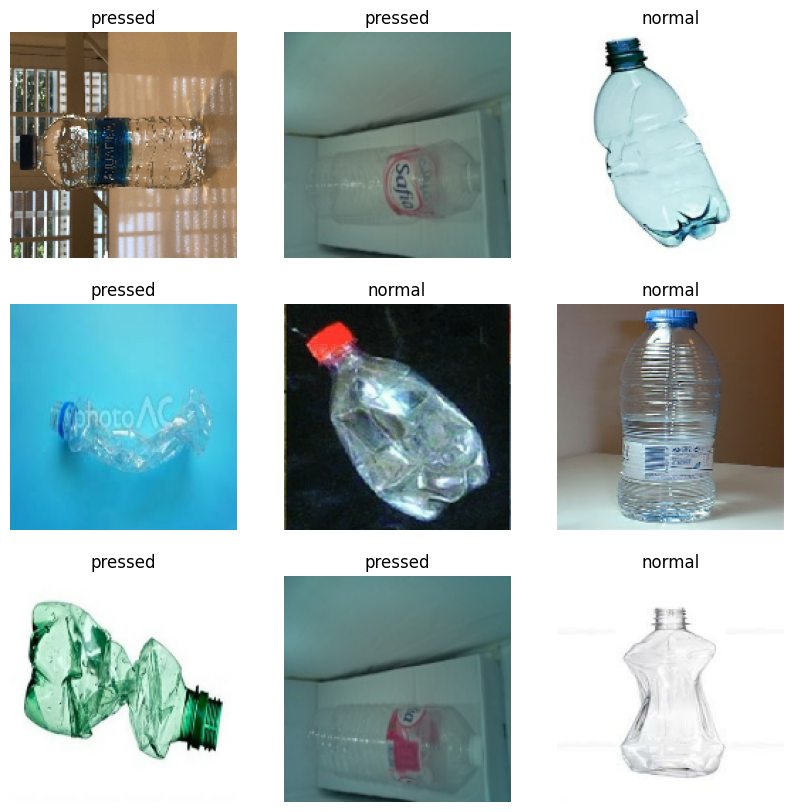

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.6, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

class_names = test_dataset.class_names

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Heatmap を作る関数

In [ ]:
make_heatmap(last_conv_layer_name, conv_base, target_image)

InvalidArgumentError: ignored

In [ ]:
def make_heatmap(last_conv_layer_name, model, target_image):
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer(last_conv_layer_name)  # 最後の畳込み層を取り出す
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(target_image)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

    heatmap_shape = (grads.shape[1], grads.shape[2])

    # ヒートマップの値を正規化
    heatmap_Emphasis = np.maximum(heatmap, 0)
    heatmap_Emphasis /= np.max(heatmap_Emphasis)
    heatmap_Emphasis = heatmap_Emphasis.reshape(heatmap_shape)
    plt.matshow(heatmap_Emphasis)
    plt.show()

    return heatmap_Emphasis

